# MALDI Data Preprocessing for c-VAE

This notebook demonstrates the preprocessing pipeline for MALDI mass spectrometry imaging data before training the conditional VAE model.

## Preprocessing Pipeline Overview:
1. Load raw MALDI data and coordinates
2. Process, clean and normalise MALDI data
3. Transform coordinate system
4. Augment data by creating samples with additional noise
5. Zero out indices in the samples (input matrix)
6. Visualise processed data
7. Save processed data

In [1]:
# Import required libraries
import os
import numpy as np
import h5py
import logging
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

os.chdir('/home/pasco/sdsc_mlibra/JupyterNotebooks/cleaned/brain_lipid_cvae_pcorso') # Replace with the path where you git-cloned the repo
# Import the preprocessing modules
from utils.dataprocessing import MALDIPreprocessor, CoordinateTransformer, DataGenerator, process_maldi_data
from utils.visualisation import ReconstructionVisualizer

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

## 1. Load raw data

First, we will load the raw MALDI data as a Parquet file.

In [2]:
# Reading Parquet file with original MALDI-MSI data using pandas
data_dir = Path("data")
df = pd.read_parquet(data_dir / 'lba_all_pixels_fully_abamapped11282023_exp_lipidclasses_allenannot_train.parquet')
print(df.items)

<bound method DataFrame.items of                             x_ccf     y_ccf     z_ccf  LPC O- 18:3  LPC 15:1  \
section1_pixel17_100     4.409796  1.227594  7.131945     0.000519  0.000369   
section1_pixel17_105     4.412813  1.206127  6.998784     0.000142  0.000100   
section1_pixel17_106     4.413417  1.201827  6.972198     0.000115  0.000100   
section1_pixel17_107     4.414021  1.197525  6.945627     0.000175  0.000100   
section1_pixel17_108     4.414626  1.193223  6.919072     0.000168  0.000100   
...                           ...       ...       ...          ...       ...   
section31_pixel237_202  13.218154  7.413906  4.458864     0.000322  0.000132   
section31_pixel238_193  13.218154  7.482028  4.678807     0.000541  0.000752   
section31_pixel238_194  13.218154  7.477240  4.653951     0.000711  0.002645   
section31_pixel238_199  13.218154  7.453215  4.529396     0.001232  0.001057   
section31_pixel238_200  13.218154  7.448390  4.504438     0.000650  0.000703   

      

## 2. Zeroing out coordinates at defined indices for testing set and remove zero values from original MALDI data

Choose the lipid to reconstruct and apply amputation operation before training to exclude testing set points.

In [3]:
coords, coords_trunc, ref_data, lipid_data, sections, indices_null, indices_zeros = process_maldi_data(df, 'SM 42:2', step=40, exclude_sections=[list(range(1, 30, 2))])

## 3. Coordinate transformation

Transform coordinates between Cartesian and spherical coordinate systems for amputated and complete coordinate arrays.

In [4]:
# Initialize coordinate transformer
coord_transformer = CoordinateTransformer()

# Transform to spherical coordinates
x, y, z = coords_trunc
xx, yy, zz = coords
r, theta, phi = coord_transformer.cartesian_to_spherical(
    x, y, z,
    center_x=(max(x)+min(x))/2,
    center_y=(max(y)+min(y))/2,
    center_z=(max(z)+min(z))/2
)
rC, thetaC, phiC = coord_transformer.cartesian_to_spherical(
    xx, yy, zz,
    center_x=(max(xx)+min(xx))/2,
    center_y=(max(yy)+min(yy))/2,
    center_z=(max(zz)+min(zz))/2
)

# Stack spherical coordinates
coords_spherical = np.vstack((r, theta, phi))
coords_complete_spherical = np.vstack((rC, thetaC, phiC))

## 4. Noised data sample generation

Generate training samples using data augmentation through noise addition to the reference data.

In [5]:
# Initialise data generator
data_generator = DataGenerator(
    original_data=ref_data,
    num_samples=2000,
    noise_type='mixed'
)

# Generate augmented samples
maldi_samples = data_generator.generate_samples()

## 5. Zeroing out the generated noised data using the previous indices 

Apply preprocessing steps to prepare the data for the c-VAE model.

In [6]:
# Amputated MALDI input matrix
maldi_processed = maldi_samples.copy()
maldi_processed[:,indices_null] = 0

logger.info(f"Spherical coordinates shape: {coords_spherical.shape}")
logger.info(f"Spherical non-zeroed out coordinates shape: {coords_spherical.shape}")
logger.info(f"Processed MALDI input matrix shape: {maldi_processed.shape}")
logger.info(f"Augmented non-zeroed out samples shape: {maldi_samples.shape}")
logger.info(f"Reference data array shape: {ref_data.shape}")
logger.info(f"Original lipid data array shape: {lipid_data.shape}")

INFO:__main__:Spherical coordinates shape: (3, 47968)
INFO:__main__:Spherical non-zeroed out coordinates shape: (3, 47968)
INFO:__main__:Processed MALDI input matrix shape: (2000, 47968)
INFO:__main__:Augmented non-zeroed out samples shape: (2000, 47968)
INFO:__main__:Reference data array shape: (47968,)
INFO:__main__:Original lipid data array shape: (47968,)


## 6. Visualise processed data

Create visualisations to verify the preprocessing results.

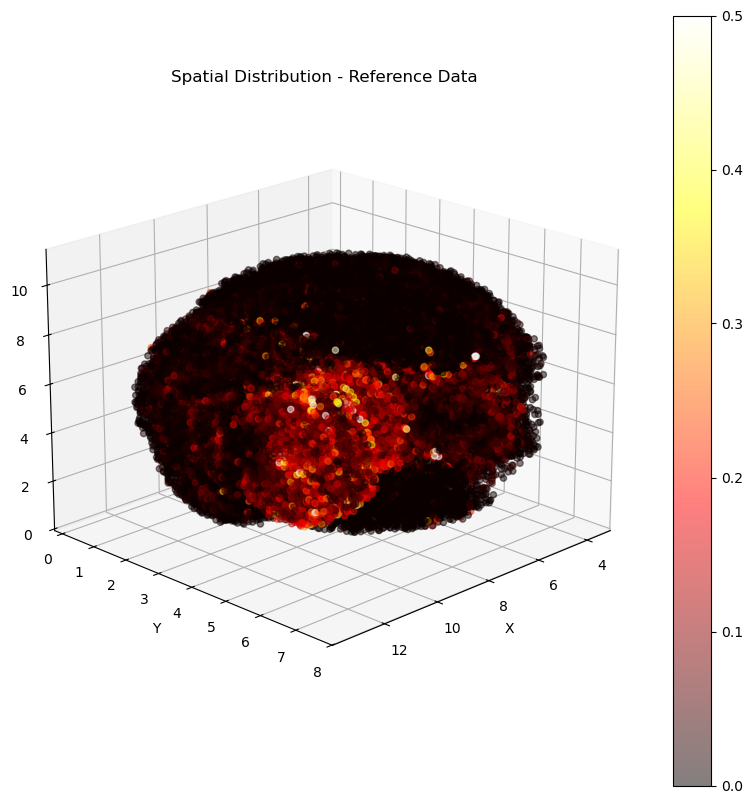

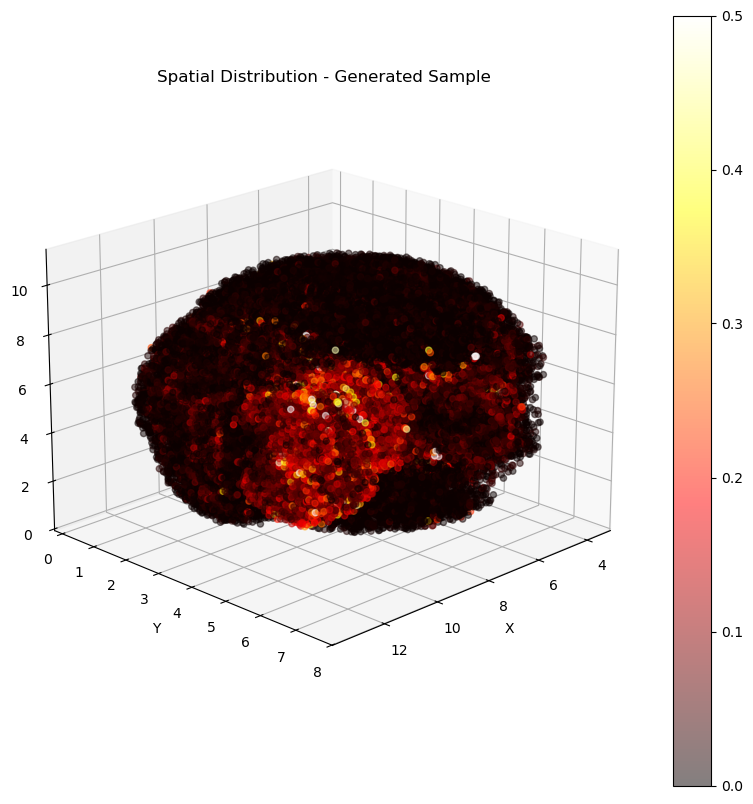

In [7]:
# Initialise visualizer
visualizer = ReconstructionVisualizer()

# Plot spatial distribution
visualizer.plot_spatial_distribution(
    values=ref_data,  
    coordinates=coords,
    title='Spatial Distribution - Reference Data',
    save_path='spatial_distribution.png'
)

# Plot spatial distribution
visualizer.plot_spatial_distribution(
    values=maldi_samples[500,:],  
    coordinates=coords,
    title='Spatial Distribution - Generated Sample',
    save_path='spatial_distribution_generatedSample.png'
)

In [ ]:
## Histograms
fig, ax = plt.subplots(figsize=(8, 6))

# Create histogram with specific number of bins
n_bins = 50  # you can adjust this
ax.hist(ref_data, bins=n_bins, density=True, alpha=0.7, color='blue', 
        edgecolor='black', label='Data')

# Add mean and std lines
mean = np.mean(ref_data)
std = np.std(ref_data)
ax.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
ax.axvline(mean + std, color='green', linestyle=':', label=f'±1 Std: {std:.2f}')
ax.axvline(mean - std, color='green', linestyle=':')

# Customize labels and title
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Reference Data')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.savefig('spatial_distribution_hist.png', dpi=400)
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))

# Create histogram with specific number of bins
n_bins = 50  # you can adjust this
ax.hist(maldi_samples[500,:], bins=n_bins, density=True, alpha=0.7, color='blue', 
        edgecolor='black', label='Data')

# Add mean and std lines
mean = np.mean(maldi_samples[500,:])
std = np.std(maldi_samples[500,:])
ax.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
ax.axvline(mean + std, color='green', linestyle=':', label=f'±1 Std: {std:.2f}')
ax.axvline(mean - std, color='green', linestyle=':')

# Customize labels and title
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Generated Sample Data')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.savefig('spatial_distribution_generatedSample_hist.png', dpi=400)
plt.show()

## 7. Save processed data

Save the preprocessed data for training the CVAE model.

In [8]:
def save_h5_data(data_dict, output_dir):
    """Save processed data to H5 files."""
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    for name, data in data_dict.items():
        with h5py.File(output_dir / f"{name}.h5", 'w') as f:
            f.create_dataset('data', data=data, compression='gzip')
        logger.info(f"Saved {name} to {output_dir / f'{name}.h5'}")

# Prepare data dictionary
processed_data = {
    'maldi_processed': maldi_processed, # To use as input matrix for training
    'coords_complete': coords_complete_spherical, # To use as conditioning for inference
    'coords_spherical': coords_spherical, # To use as conditioning for training
    'reference_data': ref_data, # To use to compute loss for training
    'maldi_samples': maldi_samples, # To check noised samples generated
    'indices_zeroedout': indices_null
}

# Save all processed data
save_h5_data(processed_data, 'data/H5')

INFO:__main__:Saved maldi_processed to data/H5/maldi_processed.h5
INFO:__main__:Saved coords_complete to data/H5/coords_complete.h5
INFO:__main__:Saved coords_spherical to data/H5/coords_spherical.h5
INFO:__main__:Saved reference_data to data/H5/reference_data.h5
INFO:__main__:Saved maldi_samples to data/H5/maldi_samples.h5
INFO:__main__:Saved indices_zeroedout to data/H5/indices_zeroedout.h5


## Summary

Preprocessing steps completed:
1. ✓ Load raw MALDI data and coordinates
2. ✓ Process, clean and normalise MALDI data
3. ✓ Transform coordinate system
4. ✓ Augment data by creating samples with additional noise
5. ✓ Zero out indices in the samples (input matrix)
6. ✓ Visualise processed data
7. ✓ Save processed data

The processed data is now ready for training the c-VAE model.